In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

In [4]:
# Вспомогательные функции

def normalize(obj):

    return obj / np.linalg.norm(obj)


def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    sin_p = 2. * (q0 * q2 - q1 * q3)
    sin_p[np.abs(sin_p) > 1] = np.sign(sin_p[np.abs(sin_p) > 1])
    pitch = np.arcsin(sin_p)
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat2rpy_deg(q0, q1, q2, q3):
    rad2deg = 180. / np.pi
       
    roll, pitch, yaw = quat2rpy(q0, q1, q2, q3)
    roll *= rad2deg
    pitch *= rad2deg
    yaw *= rad2deg

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

In [5]:
def ctrl_torque(ctrl, J, ang_vel, quat, h, trq_ext):
       
    dw = ang_vel - ctrl.omega_req
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    
    trq_ctrl = cross_product(ang_vel, J.dot(ang_vel + h)) - trq_ext - ctrl.kw * J.dot(dw) - ctrl.kq * J.dot(dq[1:])
    
    if np.max(np.abs(trq_ctrl)) > ctrl.trq_max:
        trq_ctrl *= ctrl.trq_max / np.max(np.abs(trq_ctrl))  
        
    for i in range(3):
        if np.abs(h[i]) / ctrl.h_max > 0.99 and trq_ctrl[i] * h[i] < 0:
            trq_ctrl[i] = 0          
        
    return trq_ctrl

def gravity_gradient_torque(quat, inertia_tensor, mean_motion):
    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * mean_motion ** 2. * cross_product(Ae3, inertia_tensor.dot(Ae3))    


def rhs(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
        
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)
    action = ctrl_torque(ctrl, sat.J, omega, quat, h, trq_gg)        

    x_dot = np.zeros(10)

    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    x_dot[4:7] = sat.J_inv.dot(trq_gg + action - cross_product(omega, sat.J.dot(omega + h)))
    x_dot[7:10] = - action
    
    return x_dot

In [6]:
class Parameters(object):
    pass

const = Parameters()
const.mu = 3.986e14
const.Re = 6037.1e3

sat = Parameters()
sat.J = np.diag(np.array([3, 4, 5]))
sat.J_inv = np.linalg.inv(sat.J)
sat.altitude = 600e3
sat.mean_motion = np.sqrt(const.mu / (const.Re + sat.altitude)**3.)

a = 0.25
ctrl = Parameters()
ctrl.kw = 2 * a
ctrl.kq = 2 * a**2
ctrl.trq_max = 0.05 * 100
ctrl.h_max = 0.5 * 100
ctrl.omega_req = np.array([0., sat.mean_motion, 0.])
ctrl.q_req = np.array([1., 0., 0., 0.])

x_0 = np.array([np.cos(0.25), 0., np.sin(0.25), 0.01, 0.01, 0., 0., 0., 0., 0.])

t0 = 0.
tf = 50.
t_eval = np.arange(t0, tf, 0.1)

sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t[1:]

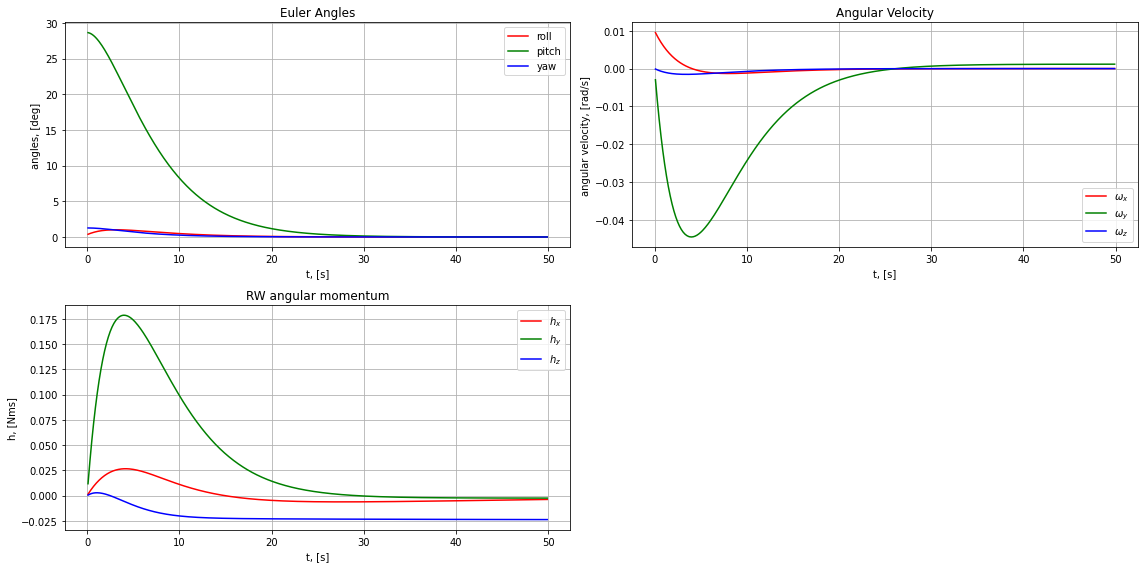

In [7]:
roll, pitch, yaw = quat2rpy_deg(x[1:,0], x[1:,1], x[1:,2], x[1:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[1:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[1:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[1:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x[1:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x[1:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x[1:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

In [38]:
def rhs_flex(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
    
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)   
    action = ctrl_torque(ctrl, sat.J, omega, quat, h, trq_gg)        

    x_dot = np.zeros(16)
    omega_dot_rigid = trq_gg + action - cross_product(omega, sat.J.dot(omega + h))
    eta_dot_flex = sat.D.dot(x[13:]) + sat.K.dot(x[10:13])

    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    tmp = omega_dot_rigid + (sat.L_p.T).dot(eta_dot_flex)
    x_dot[4:7] = sat.Aom.dot(sat.J_inv).dot(tmp)
    x_dot[7:10] = - action
    x_dot[10:13] = x[13:]
    x_dot[13:] = - sat.Aeta.dot(eta_dot_flex + sat.L_p.dot(sat.J_inv).dot(omega_dot_rigid))
        
    return x_dot

In [39]:
sat_flex = Parameters()
sat_flex.J = np.array([[75, 1, 2], [1, 40, -1], [2, -1, 80]]) # \pm20%
sat_flex.J_inv = np.linalg.inv(sat_flex.J)
sat_flex.altitude = 600e3
sat_flex.mean_motion = np.sqrt(const.mu / (const.Re + sat_flex.altitude)**3.)
sat_flex.fm_freq = np.array([5.6, 19.3, 35.4]) # flexible mode frequencies [rad/s] \pm20%
sat_flex.dzeta = np.array([0.005, 0.005, 0.005]) # flexible mode damping 
sat_flex.D = np.diag(2 * sat_flex.dzeta * sat_flex.fm_freq)
sat_flex.K = np.diag(sat_flex.fm_freq * sat_flex.fm_freq)
sat_flex.L_p = np.array([[0, 2.51, 0], [-3.84, 0, 0], [0, 12.5, 0]]) * 0.495
sat_flex.Aom = np.linalg.inv(np.identity(3) - sat_flex.J_inv.dot(sat_flex.L_p.T).dot(sat_flex.L_p))
sat_flex.Aeta = np.linalg.inv(np.identity(3) - sat_flex.L_p.dot(sat_flex.J_inv).dot(sat_flex.L_p.T))

x_0 = np.array([np.cos(0.25), 0., np.sin(0.25), 0., 0.01, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

t0 = 0.
tf = 50.
t_eval = np.arange(t0, tf, 0.1)

sol_flex = solve_ivp(lambda t, x: rhs_flex(t, x, sat_flex, ctrl), (t0,tf), x_0, t_eval = t_eval)
x_flex = sol_flex.y.T
t_flex = sol_flex.t[1:]

(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)
(4,) (3, 3) ()
(3,)


KeyboardInterrupt: ignored

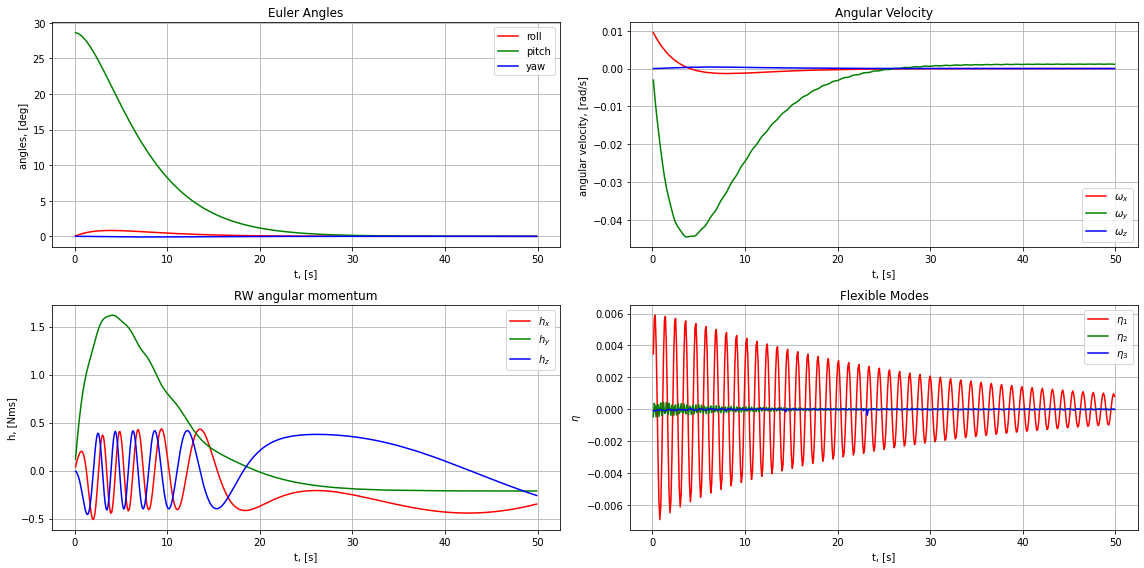

In [16]:
roll, pitch, yaw = quat2rpy_deg(x_flex[1:,0], x_flex[1:,1], x_flex[1:,2], x_flex[1:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x_flex[1:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x_flex[1:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x_flex[1:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x_flex[1:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x_flex[1:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x_flex[1:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,4)

ax2.set_title("Flexible Modes")
ax2.plot(t, x_flex[1:,13], label = '$\eta_1$', color = 'red')
ax2.plot(t, x_flex[1:,14], label = '$\eta_2$', color = 'green')
ax2.plot(t, x_flex[1:,15], label = '$\eta_3$', color = 'blue')
ax2.set_ylabel(r'$\eta$')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()